Bagian 1: Setup Lingkungan dan Pemuatan Data

In [ ]:
# Impor pustaka dasar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Impor pustaka dari scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Mengatur opsi tampilan pandas (opsional)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [ ]:
try:
    # Asumsi pemisah kolom adalah ';' dan pemisah desimal adalah ','
    # Sesuaikan parameter sep dan decimal jika file Anda berbeda
    df = pd.read_csv('datafinal.csv', sep=';', decimal=',')
    print(f"Data berhasil dimuat")
    print("\nBeberapa baris pertama data:")
    print(df.head())
    print("\nInformasi dasar DataFrame:")
    df.info()
except FileNotFoundError:
    print(f"ERROR: File tidak ditemukan di path")
    print("Pastikan path sudah benar dan file ada di Google Drive Anda.")
    print("Ingat bahwa path bersifat case-sensitive (membedakan huruf besar/kecil).")
except Exception as e:
    print(f"Terjadi kesalahan saat memuat file CSV dari Google Drive: {e}")
    print("Pastikan parameter sep (pemisah) dan decimal (desimal) sudah sesuai dengan format file Anda.")

Data berhasil dimuat

Beberapa baris pertama data:
           DateTime  LV_Active_Power_kW  Wind_Speed_ms  Theoretical_Power_Curve_KWh  Wind_Direction  filter_$
0  1/1/2018 0:00:00          380.047791       5.311336                   416.328908      259.994904         1
1  1/1/2018 0:10:00          453.769196       5.672167                   519.917511      268.641113         1
2  1/1/2018 0:20:00          306.376587       5.216037                   390.900016      272.564789         1
3  1/1/2018 0:30:00          419.645904       5.659674                   516.127569      271.258087         1
4  1/1/2018 0:40:00          380.650696       5.577941                   491.702972      265.674286         1

Informasi dasar DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   DateTime                     505

Bagian 2: Pra-pemrosesan Data

2.1. Penggantian Nama Kolom

In [ ]:
if 'df' in locals():
    print("Nama kolom awal:", df.columns.tolist())
    df.rename(columns={
        'LV_Active_Power_kW': 'LV_Active_Power',
        'Wind_Speed_ms': 'Wind_Speed',
        'Theoretical_Power_Curve_KWh': 'Theoretical_Power',
        'Wind_Direction': 'Wind_Direction_Deg', # Menambahkan _Deg untuk kejelasan
        'filter_$': 'Filter_Flag'
    }, inplace=True)
    print("Nama kolom setelah penggantian:", df.columns.tolist())
else:
    print("DataFrame 'df' tidak ditemukan. Pastikan data telah dimuat.")

Nama kolom awal: ['DateTime', 'LV_Active_Power_kW', 'Wind_Speed_ms', 'Theoretical_Power_Curve_KWh', 'Wind_Direction', 'filter_$']
Nama kolom setelah penggantian: ['DateTime', 'LV_Active_Power', 'Wind_Speed', 'Theoretical_Power', 'Wind_Direction_Deg', 'Filter_Flag']


2.2. Konversi Tipe Data

In [ ]:
if 'df' in locals():
    # Konversi DateTime
    if 'DateTime' in df.columns:
        try:
            df['DateTime'] = pd.to_datetime(df['DateTime'])
            print("\nKolom 'DateTime' berhasil dikonversi ke tipe datetime.")
        except Exception as e:
            print(f"\nGagal mengkonversi 'DateTime': {e}. Periksa formatnya.")
            # Contoh jika formatnya dd/mm/yyyy HH:MM:SS
            # df['DateTime'] = pd.to_datetime(df['DateTime'], format='%d/%m/%Y %H:%M:%S', errors='coerce')

    # Konversi Kolom Numerik
    # Daftar kolom yang seharusnya numerik
    numeric_cols_expected = ['LV_Active_Power', 'Wind_Speed', 'Theoretical_Power', 'Wind_Direction_Deg', 'Filter_Flag']
    for col in numeric_cols_expected:
        if col in df.columns:
            if df[col].dtype == 'object': # Jika masih string/object
                print(f"Kolom '{col}' bertipe object, mencoba konversi ke numerik...")
                # Menghapus spasi dan memastikan format desimal (titik) sebelum konversi
                df[col] = df[col].astype(str).str.replace(' ', '').str.replace(',', '.').astype(float)
            elif pd.api.types.is_numeric_dtype(df[col]):
                 print(f"Kolom '{col}' sudah bertipe numerik ({df[col].dtype}).")
            else: # Coba konversi paksa jika tipenya aneh
                print(f"Kolom '{col}' bertipe {df[col].dtype}, mencoba konversi paksa ke numerik...")
                df[col] = pd.to_numeric(df[col], errors='coerce') # 'coerce' akan mengubah error jadi NaN

    print("\nInfo DataFrame setelah konversi tipe data:")
    df.info()
else:
    print("DataFrame 'df' tidak ditemukan.")


Kolom 'DateTime' berhasil dikonversi ke tipe datetime.
Kolom 'LV_Active_Power' sudah bertipe numerik (float64).
Kolom 'Wind_Speed' sudah bertipe numerik (float64).
Kolom 'Theoretical_Power' sudah bertipe numerik (float64).
Kolom 'Wind_Direction_Deg' sudah bertipe numerik (float64).
Kolom 'Filter_Flag' sudah bertipe numerik (int64).

Info DataFrame setelah konversi tipe data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   DateTime            50530 non-null  datetime64[ns]
 1   LV_Active_Power     50530 non-null  float64       
 2   Wind_Speed          50530 non-null  float64       
 3   Theoretical_Power   50530 non-null  float64       
 4   Wind_Direction_Deg  50530 non-null  float64       
 5   Filter_Flag         50530 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 2.3

2.3. Penanganan Missing Values (NaN)

In [ ]:
if 'df' in locals():
    print("\nJumlah missing values per kolom (sebelum penanganan):")
    print(df.isnull().sum())

    # Strategi: Hapus baris jika ada NaN di kolom kunci untuk model
    # Kolom kunci: variabel target dan fitur utama
    cols_for_model_check_nan = ['LV_Active_Power', 'Wind_Speed', 'Theoretical_Power', 'Wind_Direction_Deg']
    # Pastikan kolom ini ada sebelum melakukan dropna
    existing_cols_for_nan_check = [col for col in cols_for_model_check_nan if col in df.columns]

    if existing_cols_for_nan_check:
        df.dropna(subset=existing_cols_for_nan_check, inplace=True)
        print(f"\nJumlah data setelah menghapus NaN pada kolom kunci: {len(df)}")
    else:
        print("Tidak ada kolom kunci yang ditemukan untuk pemeriksaan NaN.")

    print("\nJumlah missing values per kolom (setelah penanganan):")
    print(df.isnull().sum())
else:
    print("DataFrame 'df' tidak ditemukan.")


Jumlah missing values per kolom (sebelum penanganan):
DateTime              0
LV_Active_Power       0
Wind_Speed            0
Theoretical_Power     0
Wind_Direction_Deg    0
Filter_Flag           0
dtype: int64

Jumlah data setelah menghapus NaN pada kolom kunci: 50530

Jumlah missing values per kolom (setelah penanganan):
DateTime              0
LV_Active_Power       0
Wind_Speed            0
Theoretical_Power     0
Wind_Direction_Deg    0
Filter_Flag           0
dtype: int64


2.4. Aplikasi Filter (Filter_Flag)

In [ ]:
if 'df' in locals() and 'Filter_Flag' in df.columns:
    print(f"\nNilai unik di 'Filter_Flag' sebelum filter: {df['Filter_Flag'].unique()}")
    # Pastikan Filter_Flag numerik dan tidak ada NaN setelah konversi
    if pd.api.types.is_numeric_dtype(df['Filter_Flag']):
        df = df[df['Filter_Flag'] == 1].copy() # .copy() untuk menghindari SettingWithCopyWarning
        print(f"Jumlah data setelah menerapkan Filter_Flag == 1: {len(df)}")
    else:
        print("'Filter_Flag' bukan numerik atau mengandung NaN setelah konversi. Tidak dapat memfilter.")
elif 'df' in locals():
    print("\nKolom 'Filter_Flag' tidak ditemukan. Melanjutkan tanpa filter ini.")
else:
    print("DataFrame 'df' tidak ditemukan.")


Nilai unik di 'Filter_Flag' sebelum filter: [1 0]
Jumlah data setelah menerapkan Filter_Flag == 1: 50473


2.5. Feature Engineering: Transformasi Wind_Direction_Deg

In [ ]:
if 'df' in locals() and 'Wind_Direction_Deg' in df.columns:
    # Konversi derajat ke radian
    df['Wind_Dir_rad'] = np.deg2rad(df['Wind_Direction_Deg'])
    # Hitung komponen sin dan cos
    df['Wind_Dir_sin'] = np.sin(df['Wind_Dir_rad'])
    df['Wind_Dir_cos'] = np.cos(df['Wind_Dir_rad'])
    print("\nFitur 'Wind_Dir_sin' dan 'Wind_Dir_cos' telah dibuat.")
    # Kita bisa menghapus kolom perantara jika tidak diperlukan lagi
    # df.drop(columns=['Wind_Direction_Deg', 'Wind_Dir_rad'], inplace=True, errors='ignore')
elif 'df' in locals():
    print("\nKolom 'Wind_Direction_Deg' tidak ditemukan untuk feature engineering.")
else:
    print("DataFrame 'df' tidak ditemukan.")

if 'df' in locals():
    print("\nBeberapa baris data setelah pra-pemrosesan:")
    print(df.head())
    if df.empty:
        print("\nPERHATIAN: DataFrame menjadi kosong setelah pra-pemrosesan! Periksa langkah filter Anda.")


Fitur 'Wind_Dir_sin' dan 'Wind_Dir_cos' telah dibuat.

Beberapa baris data setelah pra-pemrosesan:
             DateTime  LV_Active_Power  Wind_Speed  Theoretical_Power  Wind_Direction_Deg  Filter_Flag  Wind_Dir_rad  Wind_Dir_sin  Wind_Dir_cos
0 2018-01-01 00:00:00       380.047791    5.311336         416.328908          259.994904            1      4.537767     -0.984792     -0.173736
1 2018-01-01 00:10:00       453.769196    5.672167         519.917511          268.641113            1      4.688672     -0.999719     -0.023715
2 2018-01-01 00:20:00       306.376587    5.216037         390.900016          272.564789            1      4.757153     -0.998998      0.044749
3 2018-01-01 00:30:00       419.645904    5.659674         516.127569          271.258087            1      4.734347     -0.999759      0.021956
4 2018-01-01 00:40:00       380.650696    5.577941         491.702972          265.674286            1      4.636891     -0.997151     -0.075426


Bagian 3: Analisis Data Eksploratif (EDA)

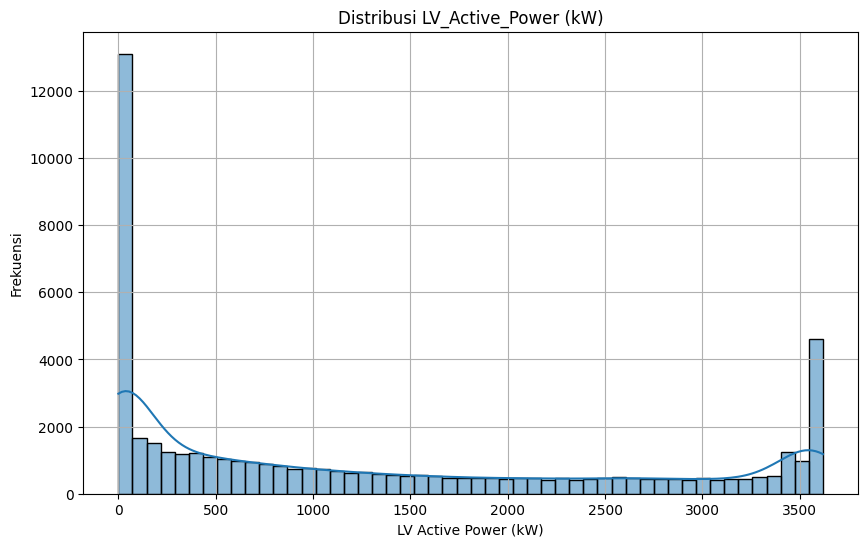

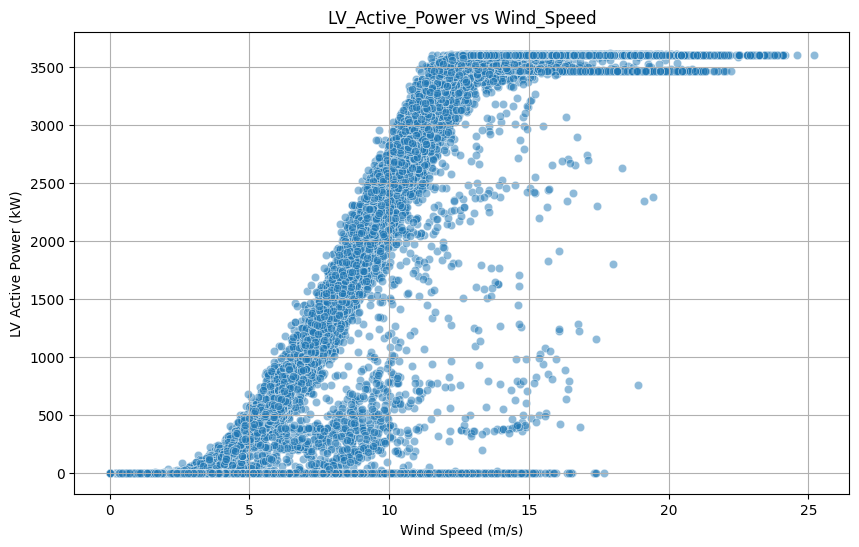

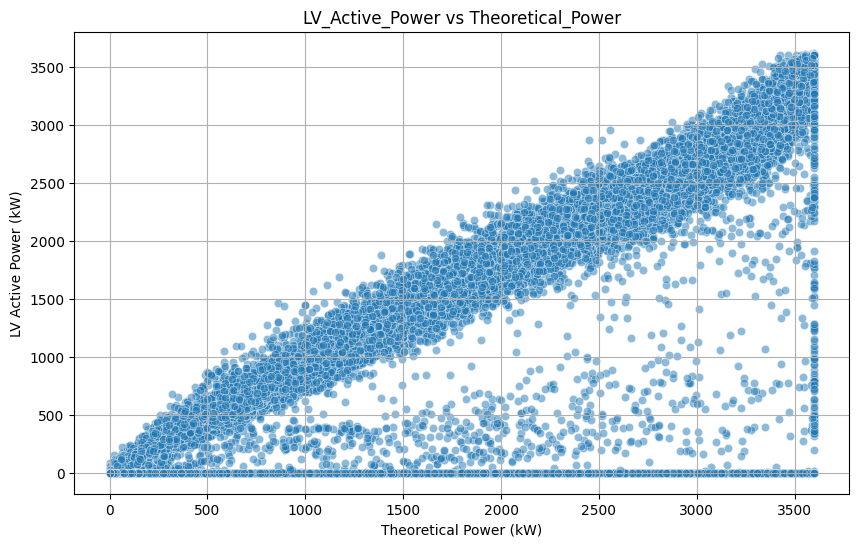

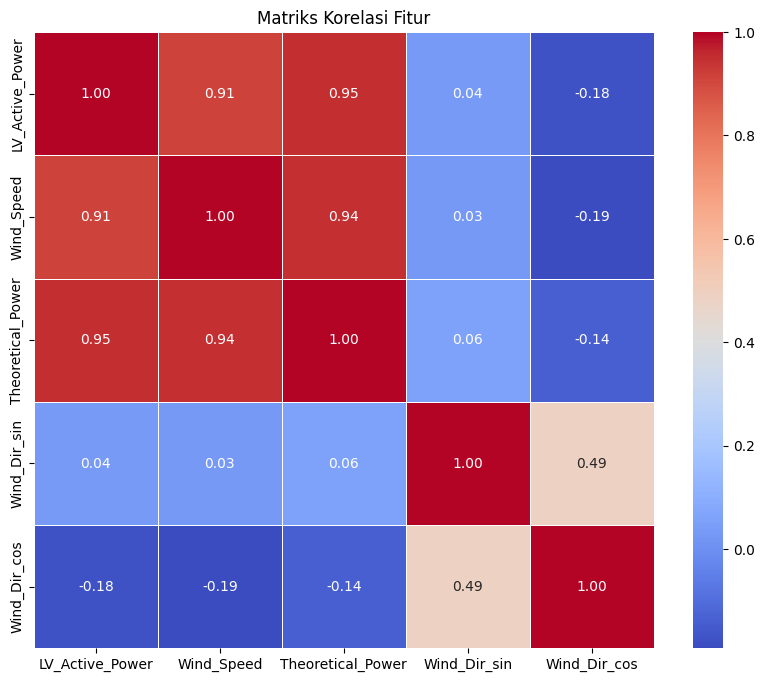


Matriks Korelasi:
                   LV_Active_Power  Wind_Speed  Theoretical_Power  Wind_Dir_sin  Wind_Dir_cos
LV_Active_Power           1.000000    0.912678           0.949861      0.035232     -0.175091
Wind_Speed                0.912678    1.000000           0.944137      0.027115     -0.191952
Theoretical_Power         0.949861    0.944137           1.000000      0.056921     -0.138521
Wind_Dir_sin              0.035232    0.027115           0.056921      1.000000      0.490908
Wind_Dir_cos             -0.175091   -0.191952          -0.138521      0.490908      1.000000


In [ ]:
if 'df' in locals() and not df.empty:
    # Distribusi Variabel Target (LV_Active_Power)
    if 'LV_Active_Power' in df.columns:
        plt.figure(figsize=(10, 6))
        sns.histplot(df['LV_Active_Power'], kde=True, bins=50)
        plt.title('Distribusi LV_Active_Power (kW)')
        plt.xlabel('LV Active Power (kW)')
        plt.ylabel('Frekuensi')
        plt.grid(True)
        plt.show()
    else:
        print("Kolom 'LV_Active_Power' tidak ditemukan untuk diplot.")

    # Scatter plot: LV_Active_Power vs Wind_Speed
    if 'LV_Active_Power' in df.columns and 'Wind_Speed' in df.columns:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='Wind_Speed', y='LV_Active_Power', data=df, alpha=0.5) # alpha untuk data padat
        plt.title('LV_Active_Power vs Wind_Speed')
        plt.xlabel('Wind Speed (m/s)')
        plt.ylabel('LV Active Power (kW)')
        plt.grid(True)
        plt.show()
    else:
        print("Kolom 'LV_Active_Power' atau 'Wind_Speed' tidak ditemukan untuk scatter plot.")

    # Scatter plot: LV_Active_Power vs Theoretical_Power
    if 'LV_Active_Power' in df.columns and 'Theoretical_Power' in df.columns:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='Theoretical_Power', y='LV_Active_Power', data=df, alpha=0.5)
        plt.title('LV_Active_Power vs Theoretical_Power')
        plt.xlabel('Theoretical Power (kW)') # Asumsi unitnya konsisten
        plt.ylabel('LV Active Power (kW)')
        plt.grid(True)
        plt.show()
    else:
        print("Kolom 'LV_Active_Power' atau 'Theoretical_Power' tidak ditemukan untuk scatter plot.")

    # Matriks Korelasi
    # Pilih fitur numerik yang relevan untuk korelasi
    cols_for_corr = ['LV_Active_Power', 'Wind_Speed', 'Theoretical_Power']
    if 'Wind_Dir_sin' in df.columns: cols_for_corr.append('Wind_Dir_sin')
    if 'Wind_Dir_cos' in df.columns: cols_for_corr.append('Wind_Dir_cos')

    # Filter hanya kolom yang benar-benar ada di DataFrame
    existing_cols_for_corr = [col for col in cols_for_corr if col in df.columns and pd.api.types.is_numeric_dtype(df[col])]

    if len(existing_cols_for_corr) > 1:
        correlation_matrix = df[existing_cols_for_corr].corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
        plt.title('Matriks Korelasi Fitur')
        plt.show()
        print("\nMatriks Korelasi:")
        print(correlation_matrix)
    else:
        print("\nTidak cukup fitur numerik yang valid untuk menghitung matriks korelasi.")
else:
    print("DataFrame 'df' tidak ditemukan atau kosong. EDA tidak dapat dilakukan.")

Bagian 4: Pemilihan Fitur dan Pembagian Data

4.1. Pemilihan Variabel Dependen (y) dan Independen (X)

In [ ]:

if 'df' in locals() and not df.empty:
    if 'LV_Active_Power' not in df.columns:
        print("Kolom target 'LV_Active_Power' tidak ditemukan. Tidak dapat melanjutkan.")
        # exit()
    else:
        y = df['LV_Active_Power']
        print(f"Variabel Dependen (y): LV_Active_Power (Shape: {y.shape})")

        # --- DEFINISI 3 SET KANDIDAT FITUR ---
        feature_sets_definitions = {
            "Model_1_TheoPower": ['Theoretical_Power'],
            "Model_2_WindSpeed": ['Wind_Speed'],
            "Model_3_Theo_and_Wind": ['Theoretical_Power', 'Wind_Speed']
        }
        # Anda bisa menambahkan fitur arah angin ke masing-masing jika diinginkan, contoh:
        # "Model_1_TheoPower_Dir": ['Theoretical_Power', 'Wind_Dir_sin', 'Wind_Dir_cos'],

        # Untuk menyimpan hasil
        model_results = {}

        # Loop melalui setiap definisi set fitur
        for model_name, feature_candidates in feature_sets_definitions.items():
            print(f"\n--- Memproses Model: {model_name} ---")
            print(f"Kandidat Fitur: {feature_candidates}")

            # 4.1. Pemilihan Variabel Independen (X) untuk model saat ini
            # Pastikan semua kandidat fitur ada di DataFrame
            X_features = [col for col in feature_candidates if col in df.columns]

            if not X_features:
                print(f"Tidak ada fitur independen yang valid ditemukan untuk {model_name}. Melanjutkan ke model berikutnya.")
                model_results[model_name] = {"Error": "Fitur tidak ditemukan"}
                continue

            X = df[X_features]
            print(f"Variabel Independen (X) terpilih untuk {model_name}: {X.columns.tolist()} (Shape: {X.shape})")

            if X.empty or y.empty or len(X) != len(y):
                print(f"Masalah dengan dimensi X atau y untuk {model_name}. Melanjutkan ke model berikutnya.")
                model_results[model_name] = {"Error": "Dimensi X/y bermasalah"}
                continue
            elif len(X) < max(10, X.shape[1] + 1) :
                print(f"PERINGATAN untuk {model_name}: Jumlah sampel ({len(X)}) sangat kecil untuk regresi yang andal dengan {X.shape[1]} fitur.")


Variabel Dependen (y): LV_Active_Power (Shape: (50473,))

--- Memproses Model: Model_1_TheoPower ---
Kandidat Fitur: ['Theoretical_Power']
Variabel Independen (X) terpilih untuk Model_1_TheoPower: ['Theoretical_Power'] (Shape: (50473, 1))

--- Memproses Model: Model_2_WindSpeed ---
Kandidat Fitur: ['Wind_Speed']
Variabel Independen (X) terpilih untuk Model_2_WindSpeed: ['Wind_Speed'] (Shape: (50473, 1))

--- Memproses Model: Model_3_Theo_and_Wind ---
Kandidat Fitur: ['Theoretical_Power', 'Wind_Speed']
Variabel Independen (X) terpilih untuk Model_3_Theo_and_Wind: ['Theoretical_Power', 'Wind_Speed'] (Shape: (50473, 2))


4.2. Pembagian Data menjadi Set Latih dan Set Uji

In [ ]:
            test_set_size = 0.2
            random_seed = 42

            # Inisialisasi variabel untuk jaga-jaga jika data tidak cukup untuk dibagi
            X_train_scaled_df = None
            X_test_scaled_df = None
            y_train_current = None
            y_test_current = None

            if len(X) * (1-test_set_size) > X.shape[1] and len(X) * test_set_size > X.shape[1]:
                X_train, X_test, y_train_current, y_test_current = train_test_split(X, y, test_size=test_set_size, random_state=random_seed)

                # Standardisasi Fitur setelah train-test split
                from sklearn.preprocessing import StandardScaler
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled = scaler.transform(X_test)

                X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
                X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

                print(f"  Ukuran X_train_scaled untuk {model_name}: {X_train_scaled_df.shape}, X_test_scaled: {X_test_scaled_df.shape}")
            else:
                print(f"  Data tidak cukup untuk dibagi untuk {model_name}. Menggunakan semua data untuk training (tidak ideal).")
                from sklearn.preprocessing import StandardScaler
                scaler = StandardScaler()
                X_scaled = scaler.fit_transform(X)
                X_train_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
                X_test_scaled_df = X_train_scaled_df.copy()
                y_train_current = y.copy()
                y_test_current = y.copy()

            if X_train_scaled_df is None or X_test_scaled_df is None:
                print(f"Gagal mempersiapkan data latih/uji yang di-scale untuk {model_name}. Melanjutkan.")
                model_results[model_name] = {"Error": "Gagal scale data"}
                continue


  Ukuran X_train_scaled untuk Model_3_Theo_and_Wind: (40378, 2), X_test_scaled: (10095, 2)


SyntaxError: 'continue' not properly in loop (<ipython-input-45-0bd81feefdb6>, line 36)

Bagian 5: Membuat dan Melatih Model Regresi Linear

In [ ]:
            print(f"\n  Melatih {model_name}...")
            linear_model = LinearRegression()
            linear_model.fit(X_train_scaled_df, y_train_current)

            coefficients = {X_train_scaled_df.columns[i]: coef for i, coef in enumerate(linear_model.coef_)}
            intercept = linear_model.intercept_

            print(f"    Intercept (β̂₀) untuk {model_name}: {intercept:.4f}")
            for feature, coef_val in coefficients.items():
                 print(f"    Koefisien untuk {feature}: {coef_val:.4f}")


            # --- (Opsional) Analisis VIF untuk Model_3_Theo_and_Wind ---
            if model_name == "Model_3_Theo_and_Wind" and 'Wind_Speed' in X_train_scaled_df.columns and 'Theoretical_Power' in X_train_scaled_df.columns:
                try:
                    from statsmodels.stats.outliers_influence import variance_inflation_factor
                    from statsmodels.tools.tools import add_constant

                    # Ambil hanya kolom yang relevan dari X_train_scaled_df jika ada lebih dari itu
                    X_vif_input = X_train_scaled_df[['Theoretical_Power', 'Wind_Speed']].copy()
                    X_vif_input_const = add_constant(X_vif_input, has_constant='add') # Tambah konstanta

                    vif_data = pd.DataFrame()
                    vif_data["feature"] = X_vif_input_const.columns
                    # Perhitungan VIF harus pada data numerik (array numpy)
                    vif_values = [variance_inflation_factor(X_vif_input_const.values, i) for i in range(X_vif_input_const.shape[1])]
                    vif_data["VIF"] = vif_values
                    print(f"\n    VIF untuk {model_name}:")
                    print(vif_data[vif_data["feature"] != "const"]) # Abaikan VIF untuk konstanta
                except ImportError:
                    print("    Paket statsmodels tidak terinstal. VIF tidak dapat dihitung.")
                except Exception as e_vif:
                    print(f"    Error saat menghitung VIF untuk {model_name}: {e_vif}")




Model regresi linear berhasil dilatih.
Koefisien Model (β̂):
  Intercept (β̂₀): -33.8059
  Koefisien untuk Theoretical_Power: 0.9044
  Koefisien untuk Wind_Dir_sin: 10.4870
  Koefisien untuk Wind_Dir_cos: -89.2303


Bagian 6: Mengevaluasi Model


Evaluasi Model pada Test Set:
  Mean Squared Error (MSE): 161256.0587
  Root Mean Squared Error (RMSE): 401.5670 (satuan sama dengan LV_Active_Power)
  R-squared (R²): 0.9065


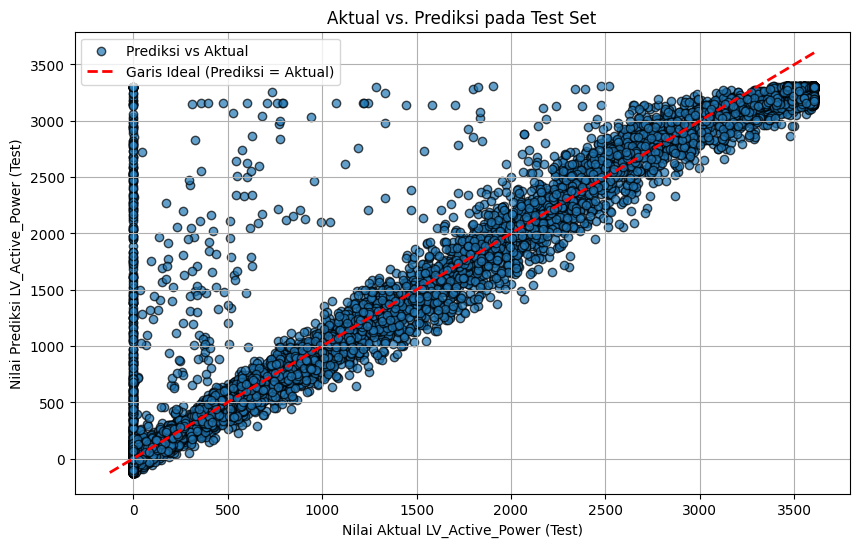

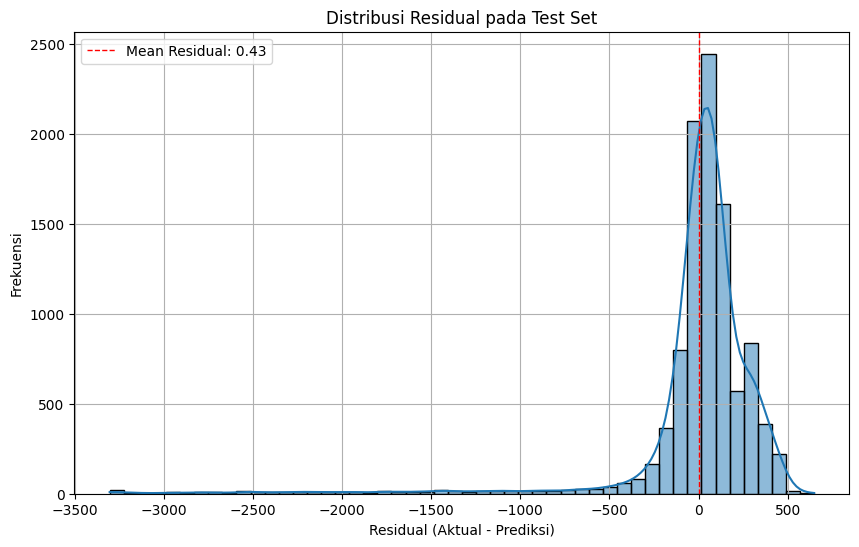

Mean residual: 0.4349 (Idealnya mendekati 0)


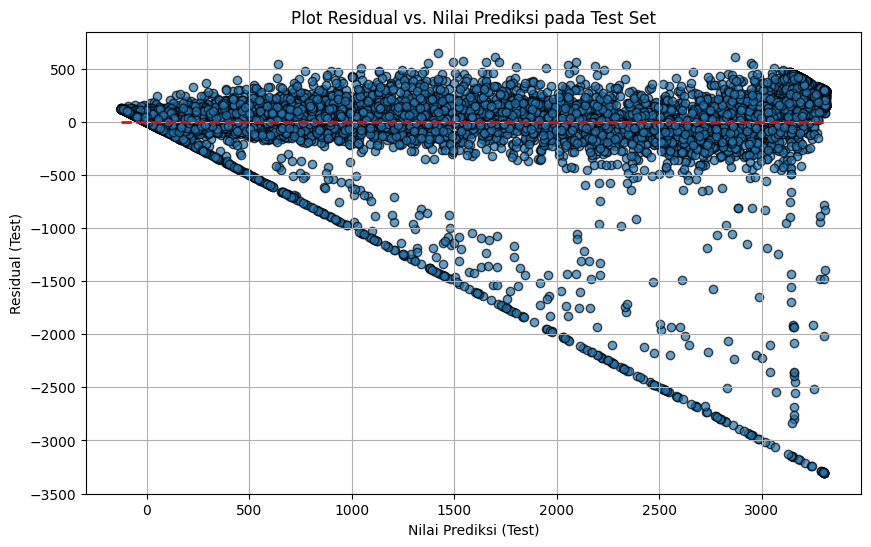

In [ ]:
            # --- Bagian 6: Mengevaluasi Model ---
            print(f"\n  Mengevaluasi {model_name}...")
            y_pred_test = linear_model.predict(X_test_scaled_df)

            mse_test = mean_squared_error(y_test_current, y_pred_test)
            rmse_test = np.sqrt(mse_test)
            r2_test = r2_score(y_test_current, y_pred_test)
            mean_resid = np.mean(y_test_current - y_pred_test)


            print(f"    Evaluasi untuk {model_name} pada Test Set:")
            print(f"      Mean Squared Error (MSE): {mse_test:.4f}")
            print(f"      Root Mean Squared Error (RMSE): {rmse_test:.4f}")
            print(f"      R-squared (R²): {r2_test:.4f}")
            print(f"      Mean Residual: {mean_resid:.4f}")

            # Simpan hasil
            model_results[model_name] = {
                "features": X_features,
                "intercept": intercept,
                "coefficients": coefficients,
                "MSE": mse_test,
                "RMSE": rmse_test,
                "R2": r2_test,
                "Mean_Residual": mean_resid,
                "VIF_data": vif_data if model_name == "Model_3_Theo_and_Wind" and 'vif_data' in locals() else None
            }

            # --- (Opsional) Plot untuk setiap model (bisa jadi banyak plot) ---
            # plt.figure(figsize=(8, 5))
            # plt.scatter(y_test_current, y_pred_test, alpha=0.6, edgecolors='k')
            # min_val = min(y_test_current.min(), y_pred_test.min())
            # max_val = max(y_test_current.max(), y_pred_test.max())
            # plt.plot([min_val, max_val], [min_val, max_val], '--r', lw=2)
            # plt.title(f'Aktual vs. Prediksi - {model_name}')
            # plt.xlabel('Aktual LV_Active_Power')
            # plt.ylabel('Prediksi LV_Active_Power')
            # plt.grid(True)
            # plt.show()

In [ ]:
        # --- Bagian 7: Perbandingan Hasil Model dan Kesimpulan ---
        print("\n\n--- Perbandingan Hasil Model ---")
        results_summary_df = pd.DataFrame()
        for name, result_data in model_results.items():
            if "Error" in result_data:
                row = {"Model": name, "Error": result_data["Error"]}
            else:
                row = {
                    "Model": name,
                    "Fitur": ", ".join(result_data["features"]),
                    "R2": result_data["R2"],
                    "RMSE": result_data["RMSE"],
                    "MSE": result_data["MSE"],
                    "Mean_Residual": result_data["Mean_Residual"]
                }
            results_summary_df = pd.concat([results_summary_df, pd.DataFrame([row])], ignore_index=True)

        print(results_summary_df.to_string()) # to_string agar semua kolom terlihat

        print("\nKesimpulan Umum dari Perbandingan:")
        # Tambahkan interpretasi Anda di sini berdasarkan tabel ringkasan
        # Contoh:
        # if "Model_1_TheoPower" in model_results and "Model_2_WindSpeed" in model_results and \
        #    "Error" not in model_results["Model_1_TheoPower"] and "Error" not in model_results["Model_2_WindSpeed"]:
        #    r2_theo = model_results["Model_1_TheoPower"]["R2"]
        #    r2_wind = model_results["Model_2_WindSpeed"]["R2"]
        #    if r2_theo > r2_wind:
        #        print("- Model_1 (Theoretical_Power) menunjukkan performa R² yang lebih baik dibandingkan Model_2 (Wind_Speed).")
        #    else:
        #        print("- Model_2 (Wind_Speed) menunjukkan performa R² yang lebih baik atau sebanding dengan Model_1 (Theoretical_Power).")

        # if "Model_3_Theo_and_Wind" in model_results and "Error" not in model_results["Model_3_Theo_and_Wind"]:
        #    vif_df = model_results["Model_3_Theo_and_Wind"].get("VIF_data")
        #    if vif_df is not None:
        #        print("- Untuk Model_3 (Theo & Wind), VIF menunjukkan:")
        #        print(vif_df[vif_df["feature"] != "const"].to_string())
        #        # Cek jika ada VIF tinggi
        #        if (vif_df[vif_df["feature"] != "const"]["VIF"] > 5).any():
        #            print("  PERHATIAN: Terdeteksi multikolinearitas tinggi pada Model_3.")
        #        else:
        #            print("  Tidak ada indikasi multikolinearitas tinggi pada Model_3 berdasarkan VIF < 5.")
        #    else:
        #        print("- VIF tidak dihitung atau gagal untuk Model_3.")
        #    # Bandingkan Model_3 dengan Model_1
        #    if "Model_1_TheoPower" in model_results and "Error" not in model_results["Model_1_TheoPower"]:
        #        r2_model3 = model_results["Model_3_Theo_and_Wind"]["R2"]
        #        r2_model1 = model_results["Model_1_TheoPower"]["R2"]
        #        if r2_model3 > r2_model1 + 0.005: # Peningkatan R2 yang sedikit berarti
        #             print(f"- Model_3 (Theo & Wind) memiliki R2 ({r2_model3:.4f}) yang lebih baik daripada Model_1 ({r2_model1:.4f}), namun perhatikan VIF.")
        #        else:
        #             print(f"- Model_3 (Theo & Wind) (R2={r2_model3:.4f}) tidak memberikan peningkatan signifikan atas Model_1 (R2={r2_model1:.4f}). Model_1 mungkin lebih disukai karena lebih sederhana.")


else:
    print("DataFrame 'df' tidak ditemukan atau kosong. Pemilihan fitur tidak dapat dilakukan.")

Bagian 8: Menyimpan Hasil Akhir

In [ ]:
if 'df' in locals() and not df.empty:
    try:
        output_file_name = 'data_angin_diolah_colab.csv'
        # Menggunakan pemisah dan desimal yang umum
        df.to_csv(output_file_name, index=False, sep=',', decimal='.')
        print(f"\nDataFrame yang telah diolah berhasil disimpan sebagai '{output_file_name}'.")
        # Untuk mengunduh file dari Colab ke komputer lokal Anda:
        # files.download(output_file_name)
    except Exception as e:
        print(f"Gagal menyimpan DataFrame: {e}")
else:
    print("DataFrame 'df' tidak ditemukan atau kosong. Tidak ada yang disimpan.")


DataFrame yang telah diolah berhasil disimpan sebagai 'data_angin_diolah_colab.csv'.
